In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [6]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=128, shuffle=True
)

In [7]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [8]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=24,kernel_size=3,stride=1,padding=1)
        #Shape= (256,24,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,24,75,75)
        
        self.conv3=nn.Conv2d(in_channels=24,out_channels=48,kernel_size=3,stride=1,padding=1)
        #Shape= (256,48,75,75)
        self.bn3=nn.BatchNorm2d(num_features=48)
        #Shape= (256,48,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,48,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 48,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
 
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,48*75*75)
        output=self.fc(output)
        
        return output

In [9]:
model=ConvNet(num_classes=2).to(device)

In [10]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [11]:
num_epochs=100

In [12]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [13]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [14]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0)        
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_relu_48channel.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(11.3713) Train Accuracy: 0.7212741751990899 Test Accuracy: 0.6303030303030303
Epoch: 1 Train Loss: tensor(5.1884) Train Accuracy: 0.745164960182025 Test Accuracy: 0.696969696969697
Epoch: 2 Train Loss: tensor(2.9837) Train Accuracy: 0.7755024649222602 Test Accuracy: 0.7818181818181819
Epoch: 3 Train Loss: tensor(1.2838) Train Accuracy: 0.8031854379977247 Test Accuracy: 0.8166666666666667
Epoch: 4 Train Loss: tensor(1.0114) Train Accuracy: 0.8183541903678423 Test Accuracy: 0.7727272727272727
Epoch: 5 Train Loss: tensor(1.6381) Train Accuracy: 0.8054607508532423 Test Accuracy: 0.7696969696969697
Epoch: 6 Train Loss: tensor(0.9002) Train Accuracy: 0.8350398179749715 Test Accuracy: 0.8348484848484848
Epoch: 7 Train Loss: tensor(0.4099) Train Accuracy: 0.8877512324611301 Test Accuracy: 0.8090909090909091
Epoch: 8 Train Loss: tensor(3.2832) Train Accuracy: 0.7686765263557073 Test Accuracy: 0.6530303030303031
Epoch: 9 Train Loss: tensor(1.6403) Train Accuracy: 0.80

Epoch: 84 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8257575757575758
Epoch: 85 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8242424242424242
Epoch: 86 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8348484848484848
Epoch: 87 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8272727272727273
Epoch: 88 Train Loss: tensor(0.0005) Train Accuracy: 1.0 Test Accuracy: 0.8151515151515152
Epoch: 89 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8393939393939394
Epoch: 90 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8242424242424242
Epoch: 91 Train Loss: tensor(0.0004) Train Accuracy: 1.0 Test Accuracy: 0.8272727272727273
Epoch: 92 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8227272727272728
Epoch: 93 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8242424242424242
Epoch: 94 Train Loss: tensor(0.0003) Train Accuracy: 1.0 Test Accuracy: 0.8363636363636363

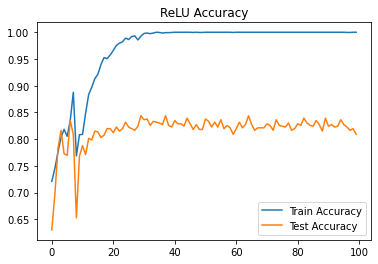

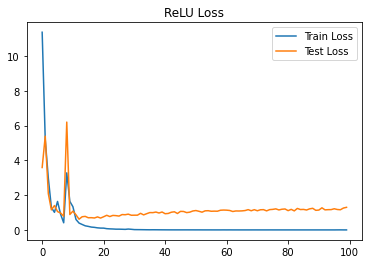

In [15]:
plt.title('ReLU Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('ReLU Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [16]:
checkpoint = torch.load('best_checkpoint_relu_48channel.model')

In [17]:
model = ConvNet(num_classes=2)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [18]:
from prettytable import PrettyTable
import torchinfo

In [19]:
def count_parameters(model):
    table = PrettyTable(['Modules', 'Parameters'])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [20]:
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    324     |
|  conv1.bias  |     12     |
|  bn1.weight  |     12     |
|   bn1.bias   |     12     |
| conv2.weight |    2592    |
|  conv2.bias  |     24     |
| conv3.weight |   10368    |
|  conv3.bias  |     48     |
|  bn3.weight  |     48     |
|   bn3.bias   |     48     |
|  fc.weight   |   540000   |
|   fc.bias    |     2      |
+--------------+------------+
Total Trainable Params: 553490


553490

In [21]:
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─ReLU: 1-3                              [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 24, 75, 75]           2,616